# Covid-19 tracker - Cases, Mortality and Vaccinations

This small prototype project is to build a webscraper capable of gathering info on the current covid-19 pandemic, and map hotzones within countries. I'll potentially be making a nice GUI for this if it works well

In [71]:
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt
import requests
import numpy as np
import pandas as pd

## Webscraping for covid-19 data using beautifulsoup.


In [72]:
# worldwide data https://www.worldometers.info/coronavirus/
# uk tracker - inc. data https://coronavirus.data.gov.uk/details/vaccinations

url = "https://www.worldometers.info/coronavirus/"
htmlContent = requests.get(url).text

soup = BeautifulSoup(htmlContent, 'html.parser')
covidTable = soup.find("table",attrs={"id": "main_table_countries_today"})

In [82]:
# extract the table headings from the soup
head = covidTable.thead.find_all("tr")
headings = []

for th in head[0].find_all("th"):
    headings.append(th.text.replace("\n", "").strip())

In [83]:
# extract actual data from the soup
body = covidTable.tbody.find_all("tr")
data = []

# iterate through every row in the html
for r in range(1,len(body)):
    row = []
    # find all column entries in that particular row
    for tr in body[r].find_all("td"):
        row.append(tr.text.replace("\n","").strip())
    len(row)
    data.append(row)

## Create a main dataframe collecting all data in the table.

In [84]:
df = pd.DataFrame(data,columns = headings)
df = df.replace(',','', regex=True)
df = df.replace('\+','', regex=True)
df


,#,"Country,Other",TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,NewRecovered,ActiveCases,"Serious,Critical",...,TotalTests,Tests/1M pop,Population,Continent,1 Caseevery X ppl,1 Deathevery X ppl,1 Testevery X ppl,New Cases/1M pop,New Deaths/1M pop,Active Cases/1M pop
0,,Asia,37972473,487687,504887,4935,32559665,390717,4907921,31099,...,,,,Asia,,,,,,
1,,South America,24421782,77010,657241,2993,21974942,7705,1789599,27504,...,,,,South America,,,,,,
2,,Europe,44139547,125727,1004477,3467,38844988,171504,4290082,31006,...,,,,Europe,,,,,,
3,,Africa,4558464,6437,120986,248,4080169,9940,357309,3798,...,,,,Africa,,,,,,
4,,Oceania,62609,38,1190,,44682,5,16737,7,...,,,,Australia/Oceania,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,218,Marshall Islands,4,,,,4,,0,,...,,,59517,Australia/Oceania,14879,,,,,
225,219,Samoa,3,,,,2,,1,,...,,,199492,Australia/Oceania,66497,,,,,5
226,220,Saint Helena,2,,,,2,,0,,...,,,6092,Africa,3046,,,,,
227,221,Micronesia,1,,,,1,,0,,...,,,116008,Australia/Oceania,116008,,,,,


# World covid-19 data
## First, let's look at extracting the data from the soup.
Below, we can extract the row from our soup that contains the cumulative world data for covid 19.

In [85]:
world_df = df.loc[df['Country,Other'] == "World"]

# strip useless columns, clean data
world_df = world_df.drop(columns=['#','Tot\xa0Cases/1M pop','1 Caseevery X ppl','1 Deathevery X ppl','1 Testevery X ppl', 'TotalTests', 'Tests/1M pop', 'Population']).reset_index(drop=True)
world_df
 
# let's plot total cases, recovered, active (serious, non-serious), deaths in a pie chart

,"Country,Other",TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,NewRecovered,ActiveCases,"Serious,Critical",Deaths/1M pop,Continent,New Cases/1M pop,New Deaths/1M pop,Active Cases/1M pop
0,World,149239098,750753,3146057,12733,127285387,641682,18807654,110929,403.6,All,,,


## Next, we can visualise some interesting data we've gathered...
Let's construct some useful graphs to display this information. To do this, let's look at using matplotlib - an essential python module for plotting, analysing and displaying data.

In [86]:
# select our data for plotting:

world_plotting_df = world_df[['TotalRecovered','Serious,Critical','ActiveCases','TotalDeaths']].astype(int)


nonCritical = world_plotting_df.iloc[0]['ActiveCases'] - world_plotting_df.iloc[0]['Serious,Critical']
world_plotting_df.iloc[0]['ActiveCases'] = nonCritical
world_plotting_df.rename(columns = {'ActiveCases':'Non-Critical, Active', 'Serious,Critical':'Critical, Active'}, inplace = True)

# let's add in percentage columns



world_plotting_df['Total Recovered Percentage'] = (world_plotting_df['TotalRecovered'] / int(world_df['TotalCases'])) * 100
world_plotting_df['Critical, Percentage'] = (world_plotting_df['Critical, Active'] / int(world_df['TotalCases'])) * 100
world_plotting_df['Non-Critical Percentage'] = (world_plotting_df['Non-Critical, Active'] / int(world_df['TotalCases'])) * 100
world_plotting_df['Death Percentage'] = (world_plotting_df['TotalDeaths'] / int(world_df['TotalCases'])) * 100


world_plotting_df

,TotalRecovered,"Critical, Active","Non-Critical, Active",TotalDeaths,Total Recovered Percentage,"Critical, Percentage",Non-Critical Percentage,Death Percentage
0,127285387,110929,18696725,3146057,85.289571,0.07433,12.528034,2.108065


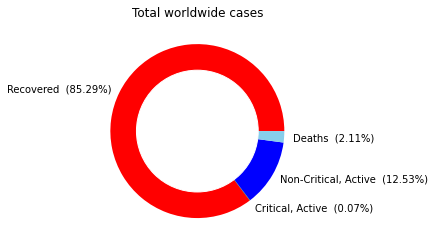

In [78]:

# grab the names and values of each piece of data
columns = world_plotting_df.columns
data = world_plotting_df.values.tolist()[0]

labels = []
x=0
for item in columns:
    if x < 4:
        labels.append(item.replace("Total","") + "  (" + str(round(world_plotting_df.iloc[0][x+4],2)) + "%)")
        x += 1


# plot the data in a donut pie chart
my_circle = plt.Circle( (0,0), 0.7, color='white')
plt.pie(data[0:4], labels=labels, colors=['red','green','blue','skyblue'])
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.title("Total worldwide cases")

# show the graph
plt.show()

## Here we extract continent data from the main dataframe, and place it in a new dataframe.

In [107]:
continents_df = df.iloc[0:5]

# strip useless columns, clean data
continents_df = continents_df.drop(columns=['#','Tot\xa0Cases/1M pop','Deaths/1M pop','1 Caseevery X ppl','1 Deathevery X ppl','1 Testevery X ppl', 'TotalTests', 'Tests/1M pop', 'Population']).reset_index(drop=True)

continents_df.drop(columns=['Continent'], inplace=True)
continents_df


,"Country,Other",TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,NewRecovered,ActiveCases,"Serious,Critical",New Cases/1M pop,New Deaths/1M pop,Active Cases/1M pop
0,Asia,37972473,487687,504887,4935,32559665,390717,4907921,31099,,,
1,South America,24421782,77010,657241,2993,21974942,7705,1789599,27504,,,
2,Europe,44139547,125727,1004477,3467,38844988,171504,4290082,31006,,,
3,Africa,4558464,6437,120986,248,4080169,9940,357309,3798,,,
4,Oceania,62609,38,1190,,44682,5,16737,7,,,


## It looks like we're missing North American data - let's pull that data from the countries dataframe

In [120]:
na = df.loc[df['Continent'] == "North America"]
del na["Continent"]

na = na.drop(columns=['#','Tot\xa0Cases/1M pop','Deaths/1M pop','1 Caseevery X ppl','1 Deathevery X ppl','1 Testevery X ppl', 'TotalTests', 'Tests/1M pop', 'Population']).reset_index(drop=True)
na = na.replace('','0', regex=True)


# create a row of data to append to the continents for North America

row = []
row.append("North America")

for column in na.columns[1:]:
    row.append(na[column].astype(float).sum())
row = [0] + row

print(row)
print(len(row))
print(continents_df.columns)
print(len(continents_df.columns))

# continents_df.append(row)
# continents_df

row[0]

[0, 'North America', 38083502.0, 53854.0, 857261.0, 1090.0, 29780235.0, 61811.0, 7446006.0, 17515.0, 1617.0, 32.7, 206902.0]
13
Index([                    0, 'Active Cases/1M pop',         'ActiveCases',
             'Country,Other',    'New Cases/1M pop',   'New Deaths/1M pop',
                  'NewCases',           'NewDeaths',        'NewRecovered',
          'Serious,Critical',          'TotalCases',         'TotalDeaths',
            'TotalRecovered'],
      dtype='object')
13


0

## Here we extract country data from the main dataframe, and place it in a new dataframe.

In [170]:
countries_df = df.loc[df['#'] != ""]

# strip useless columns, clean data
countries_df = countries_df.drop(columns=['#','Tot\xa0Cases/1M pop','Deaths/1M pop','1 Caseevery X ppl','1 Deathevery X ppl','1 Testevery X ppl', 'TotalTests', 'Tests/1M pop']).reset_index(drop=True)

countries_df.head(10)


,"Country,Other",TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,NewRecovered,ActiveCases,"Serious,Critical",Population,Continent,New Cases/1M pop,New Deaths/1M pop,Active Cases/1M pop
0,USA,32667993,65942,584209,879,25232675,55241,6851109,9975,332569103,North America,198,3,20601
1,India,16257309,332503,186928,2256,13641606,192200,2428775,8944,1390938435,Asia,239,2,1746
2,Brazil,14172139,49344,383757,2070,12673785,27653,1114597,8318,213778290,South America,231,10,5214
3,France,5408606,34318,102164,283,4243176,24569,1063266,5981,65390220,Europe,525,4,16260
4,Russia,4736121,8996,107103,397,4361807,8934,267211,2300,145985055,Europe,62,3,1830
5,Turkey,4501382,54791,37329,354,3909935,65593,554118,3463,85070186,Asia,644,4,6514
6,UK,4398431,2729,127345,18,4171798,5064,99288,276,68173867,Europe,40,0.3,1456
7,Italy,3920945,16232,118357,360,3330392,19125,472196,3021,60389901,Europe,269,6,7819
8,Spain,3456886,10814,77496,132,3156955,5368,222435,2283,46769420,Europe,231,3,4756
9,Germany,3238054,29382,81693,311,2845300,21200,311061,5049,84000346,Europe,350,4,3703


# Let's look at the continents table

C:\Users\marja\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


<AxesSubplot:xlabel='Country,Other'>

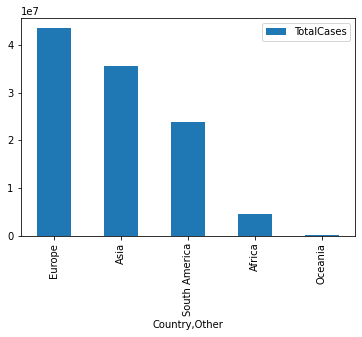

In [169]:
continent_totals_df = continents_df[['Country,Other', 'TotalCases']]
continent_totals_df.loc[:,'TotalCases'] = continent_totals_df.loc[:,'TotalCases'].astype(float)
continent_totals_df = continent_totals_df.sort_values(by=['TotalCases'],ascending=False)
continent_totals_df.plot(kind='bar', x="Country,Other", y="TotalCases")

# Let's now look at individual countries

<AxesSubplot:xlabel='Country,Other'>

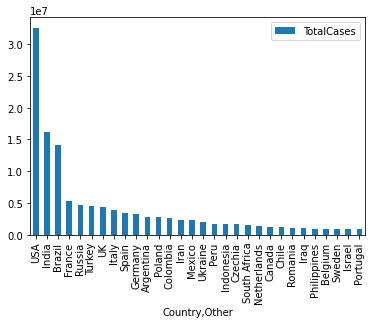

In [149]:
country_totals_df = countries_df[['Country,Other', 'TotalCases']]
country_totals_df = country_totals_df.head(30)
country_totals_df['TotalCases']=country_totals_df['TotalCases'].str.replace(',','')
country_totals_df['TotalCases'] = country_totals_df['TotalCases'].astype(float)

country_totals_df.plot(kind='bar', x="Country,Other", y="TotalCases")
